In this code, we will be applying machine learning on the data processed by TDA techniques. First, upload required modules. "gudhi" is the TDA processing module.

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import numpy as np
import mat73
import gudhi
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import math as m
import time

The data is given by a matlab structure. Upload the data using mat73

In [2]:
# /scratch/mb2864/Data/GE_Data_221013_normPH.mat
# /scratch/mb2864/Data/GEpyramids_sigma0_kappa_1_to_5_by_25_normalized_reordered.mat
def data():
    Data=mat73.loadmat('/scratch/mb2864/Data/GE_Data_221013_normPH.mat', use_attrdict=True)
    return Data

In [3]:
Data = data()

Persistence diagrams (PD) are already included in the data as Data.X.h0_t20_n (0-dimensional homology group, time=20) and Data.X.h1_t20_n (1-dimensional homology group, time=20). _n indicates that the data is normalized (mean=0, std=1). We summarize PDs via Carlsson coordinates that are given by 
\begin{aligned}
f_1&=\sum b_ip_i\\
f_2&=\sum (d_{max}-d_i)p_i\\
f_3&=\sum b_i^2p_i^4\\
f_4&=\sum (d_{max}-d_i)^2p_i^4\\
f_5&= p_{max}\\
\end{aligned}
The following code defines a function coord_matrix() that computes Carlsson coordinates for both $H_0$ and $H_1$, and stacks them as columns of the matrix $M$.

In [4]:
#Carlsson Coordinate Matrix
def coord_matrix():
    
    #gudhi.plot_persistence_diagram(data.X.h0_t20[2])
    
    f1=np.zeros([850,1])
    f2=np.zeros([850,1])
    f3=np.zeros([850,1])
    f4=np.zeros([850,1])
    f5=np.zeros([850,1])
    f6=np.zeros([850,1])
    M= np.zeros([850,10])
    
    for k in range(2):
        for j in range(850):
            if k==0:
                H0_pers=Data.X.h0_t20_n[j]
            if k==1:
                H0_pers=Data.X.h1_t20_n[j]
            H0_pers=np.array(H0_pers)    
            p=[H0_pers[i,1]-H0_pers[i,0] for i in range(len(H0_pers))]
            
            p=np.array(p)
            
            b=H0_pers[:,0]
            d=H0_pers[:,1]
            b=np.array(b)
            d=np.array(d)
            d_max=np.max(d)
            #Carlson Coordinates
            f1[j]=np.sum(d*p)/len(d) 
            f2[j]=(d_max*np.sum(p)-np.sum(d*p))/len(d)
            f3[j]=np.sum(b**2*(p)**4)/len(d)
            f4[j]=d_max**2*np.sum((1-d/d_max)**2*p**4)/len(d)
            f5[j]=np.max(p)
            #f6[j]=np.sum(1/p)
        if k==0:
            M[:,0:5]=np.concatenate((f1,f2,f3,f4,f5),axis=1)
        else:
            M[:,5:10]=np.concatenate((f1,f2,f3,f4,f5),axis=1)

    return(M)


We also utilize persistence images. For that reason we stack persistance diagrams in a single array ListOfPDs.

In [7]:
#Persistence Diagrams in a list
ListOfPDs=[]
for j in range(850):
    H0_pers=Data.X.h0_t20_n_flip[j]
    H0_pers=np.array(H0_pers)
    ListOfPDs.append(H0_pers)
    

In order to compute persistence images, we utilize gudhi.representations.PersistenceImage. We can control weights, image range and resolution. See $[\ldots]$ for reference

In [6]:
#Persistence Images
from gudhi.representations import PersistenceImage

PI = PersistenceImage(bandwidth=1, weight=lambda x: np.tanh(x[1]-x[0]), \
                                       im_range=[-4,3,-3,3],   resolution=[50,50])
pi=PI.fit_transform(ListOfPDs)


In [51]:
np.shape(ListOfPDs[1])

(528, 2)

Text(0.5, 1.0, 'Persistence Image')

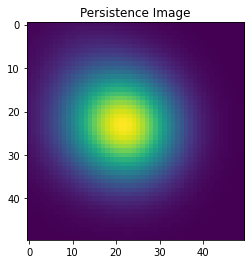

In [48]:
#Plot Persistence Images
plt.imshow(np.flip(np.reshape(pi[800], [50,50]), 0))
plt.title("Persistence Image")

Akaike Information Criterion (AIC) maybe used to determine which Carlsson coordinates are the best predictors for parameter values (via linear model). The following script computes AIC values for the output of coord_matrix() 

In [18]:
#AIC Values 
kappa=np.zeros([850,1])
for j in range(17):
    kappa[50*j:50*(j+1)]=np.array([[j*0.25+1]*50]).transpose()
    
C=coord_matrix()


a=[]
index=np.array(range(len(C[0])))

for L in range(len(index) + 1):
    for subset in itertools.combinations(index, L):
        a.append(subset)
        
a.pop(0)
AIC_values=[]
for i in range(len(a)):
    x = np.array(C[:,a[i]])
    x = sm.add_constant(x)

    model = sm.OLS(kappa, x).fit()

    AIC_values.append(np.array([a[i],model.aic]))

In [20]:
#Minimum AIC Value
AIC_values=np.array(AIC_values)
minimum_index=np.argmin(AIC_values[:,1])
Information_loss=np.array([a,[AIC_values[i][1]-AIC_values[minimum_index][1] for i in range(len(AIC_values))]])
print(AIC_values[minimum_index])
Information_loss=Information_loss.transpose()
#print(np.sort(Information_loss,axis=1))
Sorted_inf_loss=Information_loss[Information_loss[:, 1].argsort()]
print(Sorted_inf_loss[0:10])

[(0, 2, 4, 5, 6, 7, 8, 9) 939.4255446936427]
[[(0, 2, 4, 5, 6, 7, 8, 9) 0.0]
 [(0, 1, 2, 4, 5, 6, 7, 8, 9) 0.7600041464206697]
 [(0, 2, 3, 4, 5, 6, 7, 8, 9) 1.151127164781883]
 [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9) 2.2636083064587638]
 [(0, 2, 5, 6, 7, 8, 9) 4.518369867359979]
 [(0, 1, 2, 5, 6, 7, 8, 9) 4.805505602462745]
 [(0, 2, 3, 5, 6, 7, 8, 9) 5.097410715611204]
 [(0, 1, 2, 3, 5, 6, 7, 8, 9) 6.682101220045979]
 [(0, 2, 4, 5, 6, 7, 9) 22.432924013824504]
 [(0, 2, 3, 4, 5, 6, 7, 9) 24.118637548887136]]


Here we use Support Vector Machine (SVM) [ref] in order to classify parameter values using Carlsson coordinates as the input data. lbls is the vector of parameter values that we want to predict. \
Classification report includes the average accuracy of the agorithm. We also compute the confusion matrix below. With random_state=0 (seed for randomizing the data when splitting the data into train and test groups), we observe the average accuracy of 97%!
The following code can also be run with persistence images, if we replace X with pi where commented. We observe an average accuracy of 82%, for random_state=0

Classification report for classifier SVC(kernel='linear'):
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       1.00      0.71      0.83         7
         2.0       0.88      0.78      0.82         9
         3.0       0.55      0.67      0.60         9
         4.0       0.30      0.30      0.30        10
         5.0       0.50      0.50      0.50        10
         6.0       0.69      0.75      0.72        12
         7.0       0.67      0.73      0.70        11
         8.0       0.86      0.60      0.71        10
         9.0       0.86      0.60      0.71        10
        10.0       0.67      0.83      0.74        12
        11.0       0.33      0.67      0.44         3
        12.0       0.75      0.64      0.69        14
        13.0       0.44      0.33      0.38        12
        14.0       0.50      0.57      0.53         7
        15.0       0.73      0.57      0.64        14
        16.0       0.5

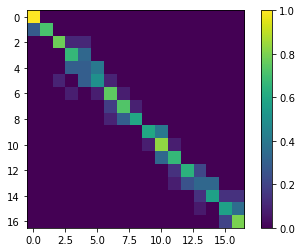

Elapsed time: 3.786507998000019 s.


In [11]:
#SVM
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

start = time.process_time()


lbls=np.zeros([850,1])
for j in range(17):
    lbls[50*j:50*j+50]=j*np.ones([50,1])
    
#X=[]
#X=coord_matrix()
#X=X[:,[5,11]]
X=pi
#X=pd.read_csv(r'Distance_matrixH_1_25_normalized.csv',header=None)
#X=np.array(X)
#X=np.delete(X,[range(50,200),range(250,400),range(450,600),range(650,800)],0)
#lbls=np.delete(lbls,[range(50,200),range(250,400),range(450,600),range(650,800)],0)

#Replace X with pi to run the code with persistence images

X_train, X_test, y_train, y_test = train_test_split(
    X, lbls, test_size=0.2, random_state=0)

clf = svm.SVC(kernel='linear',gamma='scale')

clf.fit(X_train, np.ravel(y_train))
predicted = clf.predict(X_test)

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, np.array(predicted))}\n"
)
print(metrics.accuracy_score(y_test, np.array(predicted)))
Conf_mat=confusion_matrix(y_test,np.array(predicted),normalize='true')
plt.imshow(Conf_mat)
plt.colorbar()
plt.show()


end = time.process_time()
print("Elapsed time:", (end - start) , "s.")

Here we run the previous code with all possible column combinations of coord_matrix().

In [14]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split


lbls=np.zeros([850,1])
for j in range(17):
    for i in range(50):
        lbls[50*j+i]=j
        
        
a=[]
X=coord_matrix()
accuracy=[]
index=np.array(range(len(X[0])))

for L in range(len(index) + 1):
    for subset in itertools.combinations(index, L):
        a.append(subset)
a.pop(0)
        
a=[np.array(a[i])for i in range(len(a))]        
        



for i in range(len(a)):
    Z=X[:,a[i]]

    X_train, X_test, y_train, y_test = train_test_split(
        Z, np.array(lbls), test_size=0.2, random_state=0)

    clf = svm.SVC(kernel='rbf',gamma='scale')

    clf.fit(X_train, np.ravel(y_train))
    predicted = clf.predict(X_test)
    
    accuracy.append(metrics.accuracy_score(y_test, predicted))

    
    

We observe that taking all Carlsson Coordinates is an overkill. In fact $f_3$ for $H_0$ is enough to produce an accuracy of $\approx 96\%$. We can also see that there are many combinations of just 2 columns that produce the same accuracy as all of 10 columns, e.g. $f_1$ and $f_2$ for $H_0$. Weird???

In [15]:
accuracy_with_correct_cols=np.array([a,[accuracy[i] for i in range(len(accuracy))]]).T
Sorted_accuracy=accuracy_with_correct_cols[accuracy_with_correct_cols[:, 1].argsort()]
print(Sorted_accuracy[1010:1023])
#for i in range(len(Sorted_accuracy[:,0])):
    #if len(Sorted_accuracy[i,0])==1:
        #print(Sorted_accuracy[i])
    

[[array([4, 5, 6, 7, 9]) 0.27058823529411763]
 [array([0, 4, 5, 6, 7]) 0.27058823529411763]
 [array([0, 1, 5, 6, 7, 9]) 0.27058823529411763]
 [array([0, 1, 4, 5, 6, 7]) 0.27058823529411763]
 [array([0, 5, 6, 7]) 0.27058823529411763]
 [array([1, 5, 6]) 0.2823529411764706]
 [array([1, 4, 5, 6, 7, 9]) 0.2823529411764706]
 [array([5, 6, 7]) 0.29411764705882354]
 [array([0, 1, 5, 6, 7]) 0.29411764705882354]
 [array([1, 4, 5, 6, 7]) 0.3058823529411765]
 [array([1, 5, 6, 7, 9]) 0.3058823529411765]
 [array([5, 6]) 0.31176470588235294]
 [array([1, 5, 6, 7]) 0.3352941176470588]]


Finally, we run SVM on unprocessed surfaces for comparison. First stack the surfaces (Data.X.hknorm) at time=20 as rows of an array.  

In [16]:
SurfaceStacked=np.zeros([40000,850])
for i in range(850):
    Surface=np.array(Data.X.hknorm[i])
    Surface=Surface[:,:,19]
    SurfaceColumn=np.reshape(Surface.T,(40000,1))
    SurfaceStacked[:,i] = SurfaceColumn.T

Now run the SVM code. With random_state=0, we get 66% accuracy. Moreover, we observe a significant increase in elapsed time. This took $\approx 44$ times longer to execute.

Classification report for classifier SVC(gamma='auto'):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00         9
         3.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00        10
         5.0       0.00      0.00      0.00        10
         6.0       0.00      0.00      0.00        12
         7.0       0.00      0.00      0.00        11
         8.0       0.00      0.00      0.00        10
         9.0       0.00      0.00      0.00        10
        10.0       0.00      0.00      0.00        12
        11.0       0.02      1.00      0.04         3
        12.0       0.00      0.00      0.00        14
        13.0       0.00      0.00      0.00        12
        14.0       0.00      0.00      0.00         7
        15.0       0.00      0.00      0.00        14
        16.0       0.00  

/packages/anaconda3/2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


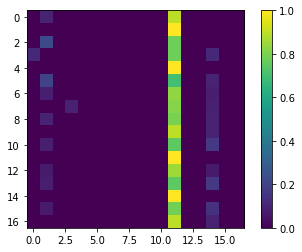

Elapsed time: 52.867463176 s.


In [46]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

start = time.process_time()
lbls=np.zeros([850,1])
for j in range(17):
    for i in range(50):
        lbls[50*j+i]=j       
        
X_train, X_test, y_train, y_test = train_test_split(
    SurfaceStacked.T, np.array(lbls), test_size=0.2, random_state=0)

clf = svm.SVC(kernel='rbf',gamma='auto')

clf.fit(X_train, np.ravel(y_train))
predicted = clf.predict(X_test)

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)
print(metrics.accuracy_score(y_test, predicted))
Conf_mat=confusion_matrix(y_test,predicted,normalize='true')
plt.imshow(Conf_mat)
plt.colorbar()
plt.show()

end = time.process_time()
print("Elapsed time:", (end - start) , "s.")

In [1]:
from sklearn.manifold import MDS

#X=coord_matrix()
X=pi

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X)

plt.plot(X_transformed)

NameError: name 'pi' is not defined

In [49]:
np.shape(X_transformed)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Classification report for classifier KNeighborsClassifier(n_neighbors=7):
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93         7
         1.0       0.62      0.62      0.62         8
         2.0       0.33      0.44      0.38         9
         3.0       0.40      0.22      0.29        18
         4.0       0.23      0.38      0.29         8
         5.0       0.45      0.62      0.53         8
         6.0       0.45      0.45      0.45        11
         7.0       0.62      0.50      0.56        10
         8.0       0.43      0.50      0.46         6
         9.0       0.60      0.38      0.46         8
        10.0       0.36      0.36      0.36        11
        11.0       0.00      0.00      0.00         6
        12.0       0.00      0.00      0.00        10
        13.0       0.08      0.10      0.09        10
        14.0       0.10      0.09      0.10        11
        15.0       0.50      0.25      0.33        12
       

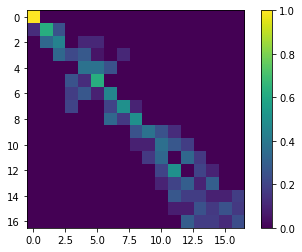

In [10]:
from sklearn import datasets, neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS

lbls=np.zeros([850,1])
for j in range(17):
    for i in range(50):
        lbls[50*j+i]=j
        
#X=pd.read_csv(r'Distance_matrixH_1_25_normalized.csv',header=None)
#X=np.array(X)

X=pi
#X=coord_matrix()


#X=SurfaceStacked.T

#embedding = MDS(n_components=2,dissimilarity="precomputed")
#X = embedding.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, np.array(lbls), test_size=0.2, random_state=10)


clf = neighbors.KNeighborsClassifier(n_neighbors=7,algorithm='auto')

clf.fit(X_train, np.ravel(y_train))

predicted = clf.predict(X_test)

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)
print(metrics.accuracy_score(y_test, predicted))
Conf_mat=confusion_matrix(y_test,predicted,normalize='true')
plt.imshow(Conf_mat)
plt.colorbar()
plt.clim([0,1])
plt.show()

In [14]:
from sklearn import datasets, neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS

lbls=np.zeros([850,1])
for j in range(17):
    for i in range(50):
        lbls[50*j+i]=j
accuracy=[]        
#X=pd.read_csv(r'Distance_matrixH_1_25_normalized.csv',header=None)
#X=np.array(X)

#X=pi
X=coord_matrix()
#embedding = MDS(n_components=2,dissimilarity="precomputed",random_state=0)
#X = embedding.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, np.array(lbls), test_size=0.2, random_state=0)

for i in range(1,100):
    clf = neighbors.KNeighborsClassifier(n_neighbors=i,algorithm='auto')

    clf.fit(X_train, np.ravel(y_train))

    predicted = clf.predict(X_test)
    accuracy.append(metrics.accuracy_score(y_test, predicted))

In [15]:
accuracy_with_correct_cols = np.array([range(1,100),[accuracy[i] for i in range(len(accuracy))]]).T
Sorted_accuracy = accuracy_with_correct_cols[accuracy_with_correct_cols[:, 1].argsort()]
print(Sorted_accuracy)

[[27.          0.11176471]
 [84.          0.11764706]
 [28.          0.11764706]
 [26.          0.11764706]
 [35.          0.11764706]
 [81.          0.11764706]
 [86.          0.11764706]
 [47.          0.11764706]
 [34.          0.11764706]
 [52.          0.12352941]
 [30.          0.12352941]
 [29.          0.12352941]
 [96.          0.12352941]
 [82.          0.12352941]
 [83.          0.12352941]
 [36.          0.12352941]
 [85.          0.12352941]
 [62.          0.12941176]
 [94.          0.12941176]
 [46.          0.12941176]
 [95.          0.12941176]
 [97.          0.12941176]
 [51.          0.12941176]
 [31.          0.12941176]
 [79.          0.12941176]
 [76.          0.13529412]
 [43.          0.13529412]
 [39.          0.13529412]
 [37.          0.13529412]
 [75.          0.13529412]
 [63.          0.13529412]
 [48.          0.13529412]
 [99.          0.13529412]
 [32.          0.13529412]
 [ 3.          0.13529412]
 [93.          0.13529412]
 [33.          0.13529412]
 

<Figure size 432x288 with 0 Axes>

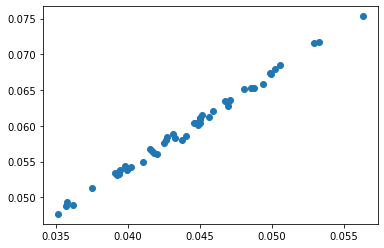

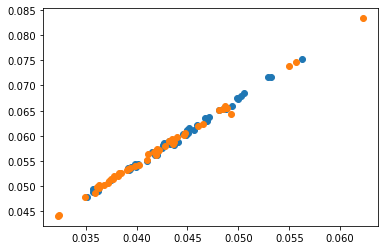

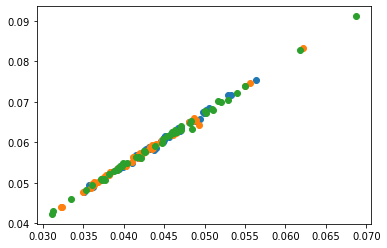

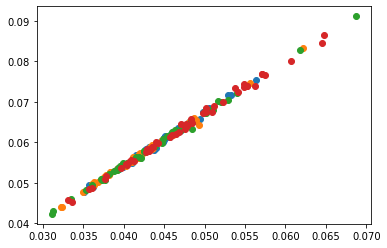

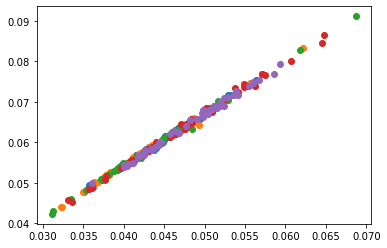

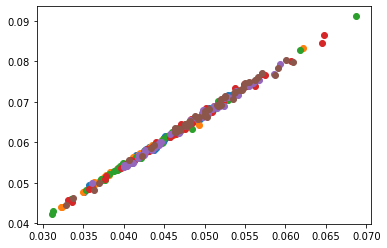

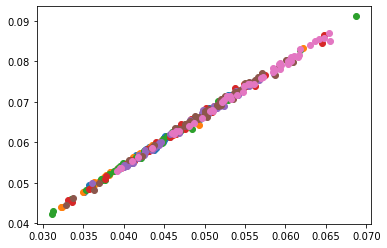

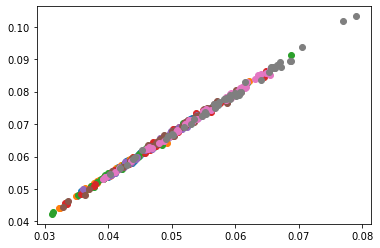

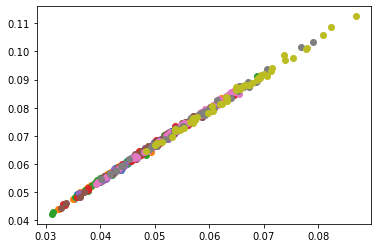

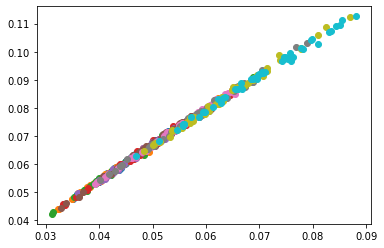

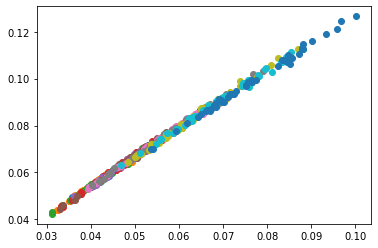

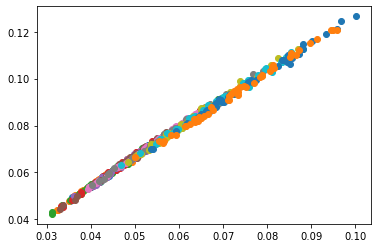

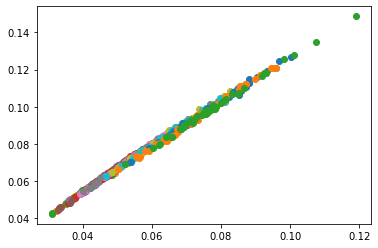

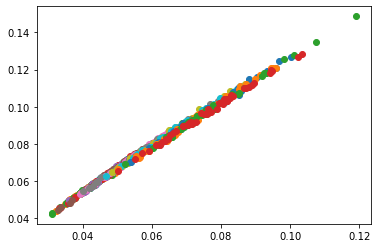

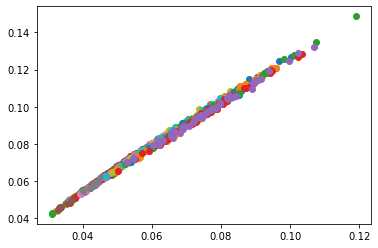

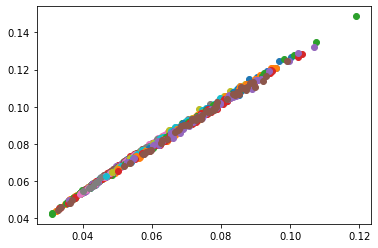

In [11]:
X=pi
for j in range(17):
    plt.figure()
    for i in range(j):
        plt.scatter(X[50*i:50*i+50,0],X[50*i:50*i+50,1])
        plt.show
    #plt.legend()

In [4]:
from sklearn.manifold import MDS
import pandas as pd
X=pd.read_csv(r'Distance_matrixH_1_25_normalized.csv',header=None)


#X=coord_matrix()
#X=pi

embedding = MDS(n_components=2,dissimilarity='precomputed')
X_transformed = embedding.fit_transform(X)


TypeError: scatter() missing 1 required positional argument: 'y'

<Figure size 432x288 with 0 Axes>

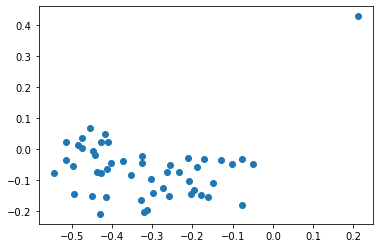

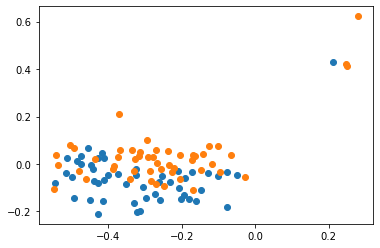

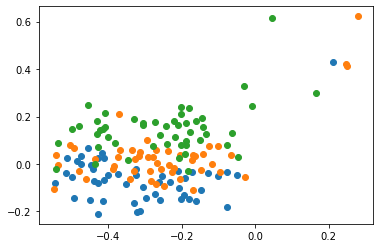

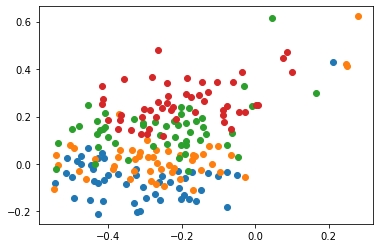

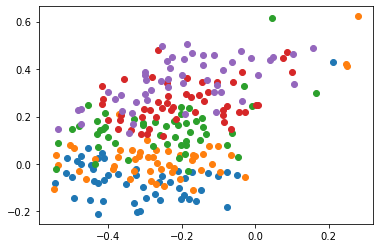

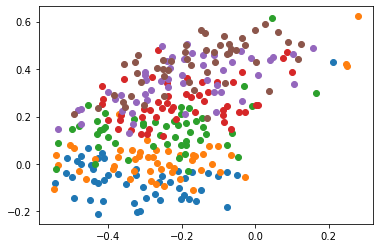

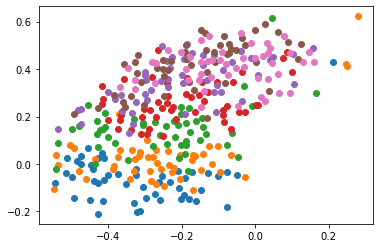

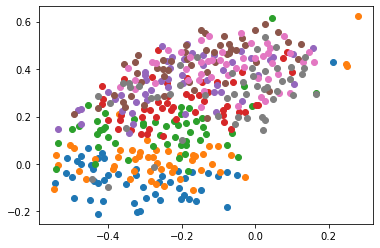

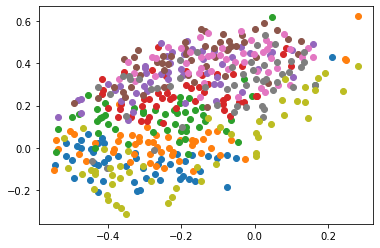

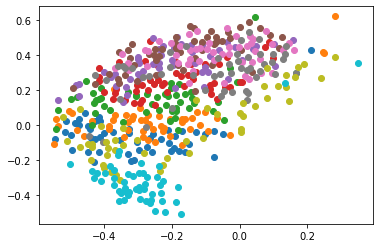

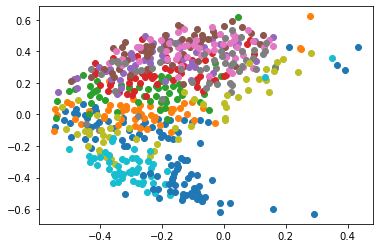

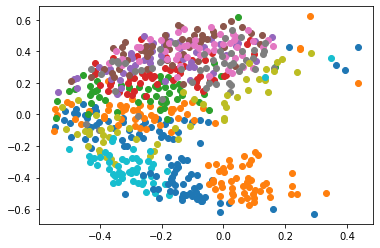

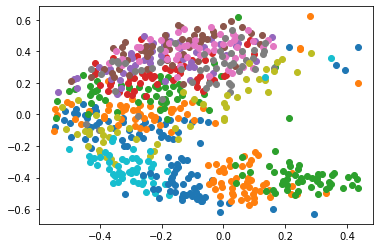

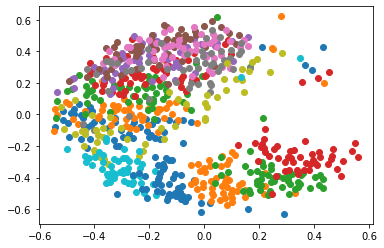

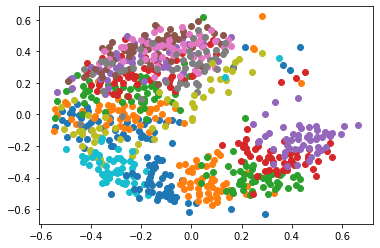

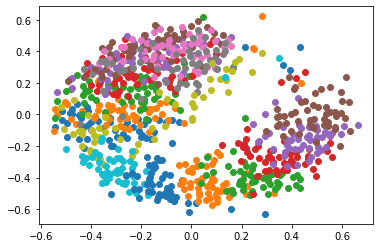

In [8]:
for j in range(17):
    plt.figure()
    for i in range(j):
        plt.scatter(X_transformed[50*i:50*i+50,0],X_transformed[50*i:50*i+50,1])
        plt.show